# Introduction

In this project we will be creating a model which is able to classify whether a blood smear is parasitized or uninfected. The model is trained on a dataset under the Tensorflow Image libraries. It is a malaria dataset which contains approximately 27,500 cell images of parasitized and uninfected cells from thin blood smear slide images of segmented cells.

In [1]:
pip install -q tfds-nightly tensorflow matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 16.4 MB/s eta 0:00:00


In [2]:
#Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D # For building neural networks
from tensorflow.keras.models import Model #Defining neural network architectures
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img  #Reading images from folders
from tensorflow.keras.models import Sequential #Defining neural network architectures
from glob import glob

In [32]:
from tensorflow.keras.applications.resnet50 import preprocess_input

## Load the dataset

In [4]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/incomplete.S88G6N_1.0.0/malaria-train.tfrecord*...:   0%|         …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [5]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


In [6]:
import os

# Define paths for train and test directories
train_path = 'cell_images/Train'
test_path = 'cell_images/Test'

# Create train and test directories if they don't exist
os.makedirs(train_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Define the number of samples for testing
num_test_samples = 1000  # Number of samples for testing

# Data Visualization

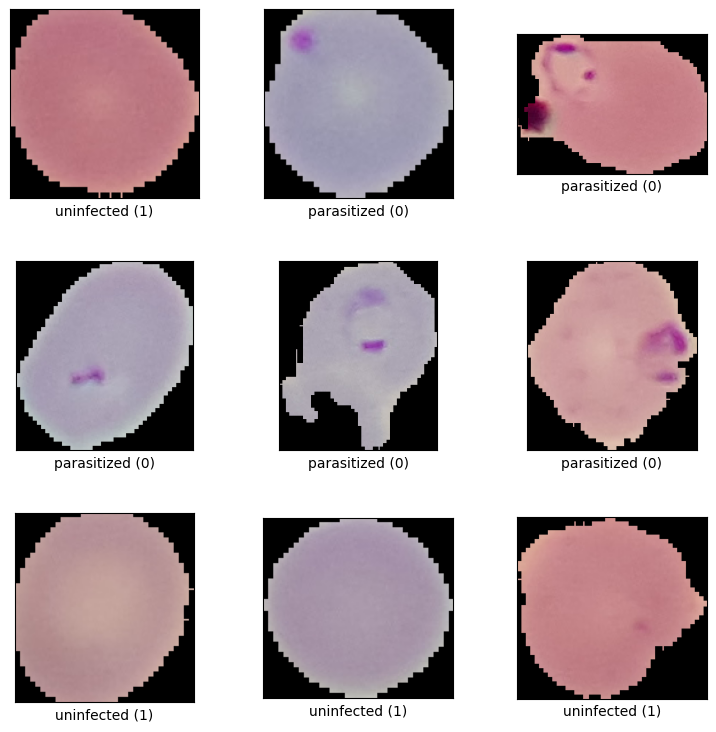

In [7]:
vis = tfds.visualization.show_examples(ds, info)

# Data Preprocessing

In [8]:
# re-size all the images to this
IMAGE_SIZE = [128, 128]

In [9]:
# Preprocess the data
def preprocess(example):
    image = tf.image.resize(example['image'], IMAGE_SIZE)  # Resize images
    label = example['label']
    return image, label

# Resize and save images to train and test directories
for i, example in enumerate(ds):
    image, label = preprocess(example)
    if i < num_test_samples:
        subset_path = test_path
    else:
        subset_path = train_path
    image_filename = f"image_{i}.jpg"
    image_path = os.path.join(subset_path, str(label.numpy()), image_filename)
    os.makedirs(os.path.dirname(image_path), exist_ok=True)
    image = tf.cast(image * 255, tf.uint8)  # Convert back to uint8 for saving
    tf.io.write_file(image_path, tf.image.encode_jpeg(image))

In [10]:
# useful for getting number of output classes
folders = glob('cell_images/Train/*')

In [11]:
folders

['cell_images/Train/0', 'cell_images/Train/1']

# Modelling

In [12]:
from tensorflow.keras.layers import MaxPooling2D

In [13]:
# Create a CNN model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding="same", activation="relu", input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(16384, activation="relu"))  # Adjust the number of units to match the output size of Flatten layer
model.add(Dense(2, activation="softmax"))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      208       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        8256      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [14]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Data Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)



test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
#Preparing training data
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (128, 128),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 26558 images belonging to 2 classes.


In [17]:
training_set

In [18]:
#Preparing training data
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (128, 128),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 1000 images belonging to 2 classes.


In [19]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
830/830 [==============================] - 149s 173ms/step - loss: 0.6935 - accuracy: 0.5864 - val_loss: 0.7988 - val_accuracy: 0.5560
Epoch 2/10
830/830 [==============================] - 140s 168ms/step - loss: 0.6273 - accuracy: 0.6489 - val_loss: 0.5810 - val_accuracy: 0.6890
Epoch 3/10
830/830 [==============================] - 140s 169ms/step - loss: 0.5927 - accuracy: 0.6847 - val_loss: 0.8081 - val_accuracy: 0.5300
Epoch 4/10
830/830 [==============================] - 140s 169ms/step - loss: 0.5541 - accuracy: 0.7173 - val_loss: 0.5354 - val_accuracy: 0.7190
Epoch 5/10
830/830 [==============================] - 139s 168ms/step - loss: 0.5020 - accuracy: 0.7602 - val_loss: 0.6241 - val_accuracy: 0.6590
Epoch 6/10
830/830 [==============================] - 139s 168ms/step - loss: 0.4258 - accuracy: 0.8045 - val_loss: 0.8545 - val_accuracy: 0.6240
Epoch 7/10
830/830 [==============================] - 137s 165ms/step - loss: 0.3683 - accuracy: 0.8425 - val_loss: 0.8401 -

# Evaluation Metrics

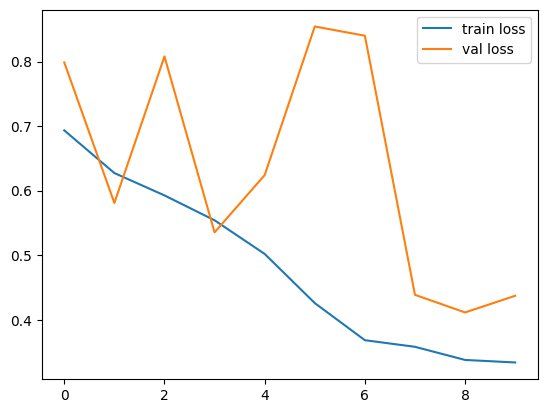

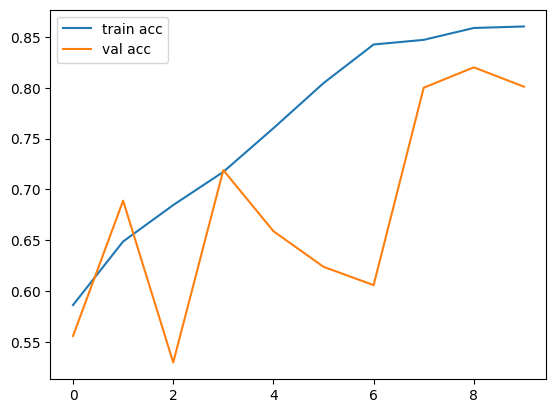

<Figure size 640x480 with 0 Axes>

In [20]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

# Model Saving and Prediction

In [21]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_CNN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [22]:
y_pred = model.predict(test_set)

32/32 [==============================] - 1s 25ms/step


In [23]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [24]:
y_pred

array([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [40]:
#Importing load model function and images preprocessing module
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [41]:
model=load_model('model_CNN.h5')

In [42]:
img=image.load_img('cell_images/Test/0/image_102.jpg',target_size=(128,128))

In [43]:
x=image.img_to_array(img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [44]:
x.shape

(128, 128, 3)

In [45]:
x=x/255

In [46]:
#Preprocessing of an image array
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 128, 128, 3)

In [47]:
model.predict(img_data)

1/1 [==============================] - 1s 547ms/step


array([[1., 0.]], dtype=float32)

In [48]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 17ms/step


In [49]:
if(a==1):
    print("Uninfected")
else:
    print("Infected")

Infected
